In [3]:
import os
import numpy as np
import pandas as pd
import scipy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold
from mllib.model import KerasSurrogate
from helper_functions.scan_helper_functions import AdjustedRSquared
from helper_functions.ml_helper_functions import RSquaredSeparated, AdjustedRSquaredSeparated
from helper_functions.invertible_neural_network import InvertibleNetworkSurrogate
from sklearn.metrics import mean_absolute_error, mean_squared_error, explained_variance_score,mean_absolute_percentage_error

In [4]:
seed = 49857
tf.random.set_seed(seed)
np.random.seed(seed)

# Config

In [5]:
directory = os.path.dirname(os.path.dirname(os.getcwd()))
directory = '/data/project/general/aerosolretriev/aerosol_results_rb/simulated_data/real_meas_scan_532'


In [6]:
test_datafile = '/data/user/boiger_r/aerosol/aerosol_data/raw_data_prep_for_meas/logP11_532/training_dataset.hdf5'

In [7]:
model_name = 'invertible_model'
val_model_name = 'forward_model'

In [8]:
plot_dir = directory + '/plots/model'
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

model_dir = directory + '/model'
#if not os.path.exists(model_dir):
#    os.makedirs(model_dir)

# Load the model and the data (dvar, qoi) for testing

In [9]:
custom_objects = {'AdjustedRSquared': AdjustedRSquared}

kwargs = {'custom_objects': custom_objects,'compile': False}

surr = InvertibleNetworkSurrogate.load(model_dir, model_name, model_kwargs=kwargs)

In [10]:
dvar_test = pd.read_hdf(test_datafile,key = 'dvar')
qoi_test = pd.read_hdf(test_datafile,key = 'qoi')
dvar_test.reset_index(drop=True, inplace=True)
qoi_test.reset_index(drop=True, inplace=True)

In [11]:
dvar_test.describe()

V_tot      R_median           GSD       n_532nm       k_532nm
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000
mean    2498.319129      1.323625      1.424970      1.465169      0.063157
std     1444.271233      0.678193      0.014411      0.077867      0.042108
min        1.034816      0.150007      1.400000      1.330001      0.000048
25%     1244.473107      0.736788      1.412477      1.397952      0.028986
50%     2501.267382      1.324012      1.424957      1.465248      0.058024
75%     3749.111150      1.910658      1.437454      1.532740      0.089729
max     4999.961568      2.499997      1.450000      1.599998      0.199485

In [12]:
qoi_test

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -18.431509    -18.808109    -19.127055    -19.407179    -19.651751   
1        -18.502498    -18.842214    -19.103957    -19.301194    -19.465629   
2        -17.638104    -17.908516    -18.092529    -18.253473    -18.394331   
3        -16.226951    -16.528202    -16.814829    -17.108302    -17.380616   
4        -18.850065    -19.135665    -19.377091    -19.548557    -19.709667   
...             ...           ...           ...           ...           ...   
79995    -17.031865    -17.396289    -17.712251    -18.003946    -18.265131   
79996    -14.946357    -14.997885    -15.053178    -15.114380    -15.173879   
79997    -15.879866    -15.905892    -15.934192    -15.965890    -15.997029   
79998    -17.459646    -17.798922    -18.108062    -18.414897    -18.693645   
79999    -15.164278    -15.331731    -15.497949    -15.668103    -15.829914   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0        -19.888793    -20.075430    -20.230339    -20.386865    -20.553607   
1        -19.671920    -19.860418    -20.010218    -20.144912    -20.282949   
2        -18.550755    -18.680851    -18.777284    -18.856662    -18.933241   
3        -17.640118    -17.866681    -18.082211    -18.298109    -18.505128   
4        -19.833524    -19.936446    -20.029469    -20.123166    -20.217413   
...             ...           ...           ...           ...           ...   
79995    -18.499908    -18.674361    -18.815725    -18.954383    -19.096892   
79996    -15.238676    -15.306011    -15.375492    -15.446887    -15.519864   
79997    -16.031459    -16.067783    -16.105969    -16.145878    -16.187424   
79998    -18.965218    -19.192395    -19.396138    -19.594060    -19.777144   
79999    -15.992433    -16.150505    -16.302692    -16.445961    -16.576171   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      ...     -24.513248     -24.512894     -24.513957     -24.516529   
1      ...     -24.293438     -24.273845     -24.251320     -24.227759   
2      ...     -22.174718     -22.142538     -22.099689     -22.056512   
3      ...     -22.632526     -22.639637     -22.648374     -22.658157   
4      ...     -22.804229     -22.724192     -22.664268     -22.622187   
...    ...            ...            ...            ...            ...   
79995  ...     -22.690522     -22.681765     -22.673646     -22.663433   
79996  ...     -20.076163     -20.081044     -20.086583     -20.092420   
79997  ...     -20.592940     -20.588123     -20.582287     -20.575363   
79998  ...     -24.266868     -24.264795     -24.264174     -24.265382   
79999  ...     -19.329301     -19.315063     -19.312230     -19.324821   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
0         -24.520443     -24.525448     -24.531064     -24.536530   
1         -24.204676     -24.184372     -24.170204     -24.165504   
2         -21.992595     -21.890393     -21.781869     -21.694541   
3         -22.668107     -22.677380     -22.684960     -22.689664   
4         -22.583861     -22.541944     -22.505867     -22.473404   
...              ...            ...            ...            ...   
79995     -22.648717     -22.628082     -22.601302     -22.568489   
79996     -20.097916     -20.102474     -20.105327     -20.105920   
79997     -20.567459     -20.558684     -20.549060     -20.538697   
79998     -24.268772     -24.274472     -24.282416     -24.292231   
79999     -19.354754     -19.401937     -19.466397     -19.548156   

       P11_0.532_169  P11_0.532_170  
0         -24.541161     -24.544124  
1         -24.171869     -24.188906  
2         -21.618970     -21.562642  
3         -22.690737     -22.687595  
4         -22.423614     -22.372849  
...              ...            ...  
79995     -22.529631     -22.484981  
79996     -20.103658     -20.098237  
79997     -20.527864     -20.516821  
79998     -

In [13]:
qoi_test.describe()

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000   
mean     -17.169682    -17.421165    -17.643327    -17.845421    -18.028441   
std        1.411456      1.481100      1.535457      1.572994      1.605458   
min      -25.788759    -26.148576    -26.435766    -26.654463    -26.837802   
25%      -18.022845    -18.340207    -18.610299    -18.836761    -19.038646   
50%      -17.122453    -17.422073    -17.684690    -17.927693    -18.149433   
75%      -16.070020    -16.262463    -16.442774    -16.626520    -16.802214   
max      -14.477508    -14.544637    -14.608390    -14.658342    -14.706377   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000   
mean     -18.209465    -18.367385    -18.507405    -18.642378    -18.775554   
std        1.640547      1.665078      1.679254      1.692255      1.708167   
min      -27.047242    -27.228761    -27.375527    -27.517692    -27.671343   
25%      -19.246000    -19.423449    -19.568777    -19.708778    -19.852443   
50%      -18.358129    -18.530378    -18.683059    -18.828333    -18.970351   
75%      -16.973415    -17.135748    -17.289892    -17.438443    -17.581390   
max      -14.758813    -14.813011    -14.862138    -14.913083    -14.965627   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
count  ...   80000.000000   80000.000000   80000.000000   80000.000000   
mean   ...     -22.576266     -22.562733     -22.551749     -22.543875   
std    ...       1.682715       1.682619       1.682210       1.681657   
min    ...     -31.662109     -31.655989     -31.650295     -31.645797   
25%    ...     -23.689371     -23.678015     -23.665647     -23.656366   
50%    ...     -22.664756     -22.648100     -22.635499     -22.627813   
75%    ...     -21.319318     -21.308730     -21.300921     -21.296885   
max    ...     -18.271313     -18.239360     -18.199219     -18.150348   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
count   80000.000000   80000.000000   80000.000000   80000.000000   
mean      -22.537771     -22.532599     -22.530018     -22.530806   
std         1.681520       1.682609       1.685202       1.689443   
min       -31.643307     -31.643472     -31.646462     -31.652134   
25%       -23.648577     -23.644447     -23.640746     -23.643469   
50%       -22.620786     -22.617124     -22.617257     -22.623825   
75%       -21.293050     -21.289750     -21.288812     -21.287457   
max       -18.092745     -18.027153     -17.954873     -17.877833   

       P11_0.532_169  P11_0.532_170  
count   80000.000000   80000.000000  
mean      -22.533148     -22.536976  
std         1.696204       1.705358  
min       -31.659746     -31.668154  
25%       -23.649715     -23.660852  
50%       -22.630975     -22.642154  
75%       -21.284653     -21.282363  
max       -17.798063     -17.717831  

[8 rows x 160 columns]

In [14]:
qoi_columns = qoi_test.columns
dvar_columns = dvar_test.columns

In [15]:
qoi_test_plot = qoi_test.copy()

# Prediction

## Forward Prediction

In [16]:
import time
start = time.time()
qoi_pred_fw = surr.predict(dvar_test.values)
end = time.time()
time = (end-start)/len(dvar_test)
time

0.00010945859849452973

In [17]:
qoi_columns

Index(['P11_0.532_10', 'P11_0.532_11', 'P11_0.532_12', 'P11_0.532_13',
       'P11_0.532_14', 'P11_0.532_15', 'P11_0.532_16', 'P11_0.532_17',
       'P11_0.532_18', 'P11_0.532_19',
       ...
       'P11_0.532_161', 'P11_0.532_162', 'P11_0.532_163', 'P11_0.532_164',
       'P11_0.532_165', 'P11_0.532_166', 'P11_0.532_167', 'P11_0.532_168',
       'P11_0.532_169', 'P11_0.532_170'],
      dtype='object', length=160)

In [18]:
qoi_pred_fw.shape

(80000, 160)

In [19]:
qoi_pred_fw = pd.DataFrame(data=qoi_pred_fw, columns=qoi_columns)
qoi_pred_fw

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0        -18.436596    -18.813206    -19.097402    -19.391112    -19.636141   
1        -18.473250    -18.833959    -19.112913    -19.319681    -19.475849   
2        -17.601418    -17.869969    -18.092166    -18.262621    -18.406707   
3        -16.231623    -16.516086    -16.831254    -17.136137    -17.420344   
4        -18.854232    -19.144171    -19.364509    -19.503474    -19.664982   
...             ...           ...           ...           ...           ...   
79995    -17.037984    -17.418031    -17.712511    -18.020599    -18.258270   
79996    -14.985841    -14.978807    -15.008262    -15.083691    -15.200509   
79997    -15.872205    -15.880341    -15.956771    -15.915266    -15.959412   
79998    -17.501147    -17.791904    -18.135988    -18.472502    -18.689347   
79999    -15.137715    -15.308678    -15.460722    -15.669316    -15.871037   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0        -19.867782    -20.040108    -20.213767    -20.354513    -20.546274   
1        -19.699336    -19.871151    -20.004289    -20.152964    -20.275724   
2        -18.591270    -18.675535    -18.829939    -18.926758    -18.943161   
3        -17.683422    -17.905945    -18.093124    -18.314652    -18.536464   
4        -19.803962    -19.925020    -20.051053    -20.129386    -20.191169   
...             ...           ...           ...           ...           ...   
79995    -18.485109    -18.683225    -18.810965    -18.976235    -19.088916   
79996    -15.234498    -15.307026    -15.416070    -15.470956    -15.505713   
79997    -15.991657    -16.048516    -16.091951    -16.151356    -16.152104   
79998    -18.985974    -19.209673    -19.391188    -19.578387    -19.779424   
79999    -16.003574    -16.166474    -16.350840    -16.483919    -16.568974   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      ...     -24.451594     -24.471011     -24.476469     -24.499673   
1      ...     -24.287412     -24.278258     -24.224111     -24.252525   
2      ...     -22.209564     -22.181123     -22.121647     -22.080791   
3      ...     -22.655937     -22.690675     -22.653824     -22.699378   
4      ...     -22.828863     -22.773681     -22.692001     -22.650408   
...    ...            ...            ...            ...            ...   
79995  ...     -22.658803     -22.697394     -22.679620     -22.668880   
79996  ...     -20.061422     -20.090088     -20.093389     -20.123366   
79997  ...     -20.569825     -20.546091     -20.533104     -20.558917   
79998  ...     -24.240992     -24.232870     -24.260112     -24.272352   
79999  ...     -19.378762     -19.432492     -19.335863     -19.371050   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
0         -24.515005     -24.507962     -24.498319     -24.549999   
1         -24.232276     -24.190928     -24.179729     -24.172345   
2         -22.022077     -21.902357     -21.799920     -21.746300   
3         -22.717480     -22.681580     -22.681602     -22.717968   
4         -22.580113     -22.468842     -22.471698     -22.517823   
...              ...            ...            ...            ...   
79995     -22.657786     -22.648274     -22.609949     -22.590510   
79996     -20.140164     -20.129042     -20.135032     -20.176868   
79997     -20.549210     -20.482203     -20.516807     -20.556065   
79998     -24.234768     -24.274730     -24.287674     -24.273266   
79999     -19.414583     -19.456209     -19.435490     -19.549148   

       P11_0.532_169  P11_0.532_170  
0         -24.543517     -24.506968  
1         -24.144666     -24.198841  
2         -21.671414     -21.589270  
3         -22.674282     -22.698497  
4         -22.445691     -22.399208  
...              ...            ...  
79995     -22.544865     -22.473955  
79996     -20.209322     -20.155381  
79997     -20.524281     -20.556818  
79998     -

In [20]:
qoi_pred_plot_fw = qoi_pred_fw.copy()
#qoi_pred_plot_fw

## Inverse prediction

In [21]:
import time
n_tries = 32
start = time.time()
dvar_pred_iv = surr.sample_n_tries(qoi_test.values, batch_size=128, n_tries=n_tries)
end = time.time()
iv_time = (end-start)/len(qoi_test)
iv_time

0.007904150444269181

In [22]:
dvar_columns

Index(['V_tot', 'R_median', 'GSD', 'n_532nm', 'k_532nm'], dtype='object')

In [23]:
dvar_pred_iv = pd.DataFrame(data=dvar_pred_iv, columns=dvar_columns)
dvar_pred_iv

V_tot  R_median       GSD   n_532nm   k_532nm
0      1044.704017  1.750371  1.441609  1.479788  0.118877
1      2126.122243  2.309098  1.432389  1.401500  0.056134
2      2926.927000  2.005146  1.413557  1.377389  0.012093
3      3778.221324  1.175435  1.446510  1.532396  0.140047
4       839.416691  1.987569  1.442776  1.491380  0.012647
...            ...       ...       ...       ...       ...
79995  3314.529041  1.599612  1.435713  1.572604  0.051355
79996  3579.849865  0.355590  1.428748  1.380270  0.014425
79997  1993.379158  0.235946  1.421818  1.492528  0.046619
79998  1440.417601  1.367827  1.441166  1.363297  0.140380
79999  4903.099673  0.813879  1.439157  1.419253  0.013043

[80000 rows x 5 columns]

In [24]:
dvar_pred_iv.describe()

V_tot      R_median           GSD       n_532nm       k_532nm
count  80000.000000  80000.000000  80000.000000  80000.000000  80000.000000
mean    2498.250844      1.324123      1.425193      1.463737      0.061911
std     1450.740700      0.675093      0.012653      0.077708      0.040435
min     -230.274031      0.040928      1.399286      1.314904     -0.007655
25%     1224.379273      0.742369      1.414418      1.396179      0.028725
50%     2504.377882      1.325984      1.424816      1.463943      0.056718
75%     3772.698122      1.905017      1.436502      1.531530      0.087296
max     5314.264741      2.578333      1.449663      1.623845      0.203796

# Calculate metrics

## R2

Use either R2 or adjusted R2

R2 = 1 - residual_sum_of_squares / total_sum_of_squares =  $1- \frac{\sum{(y_{true}-y_{pred})^2}}{ \sum{(y_{true}-\bar{y}_{true})}}$


adjusted R2 = $1- \frac{(1-R2)(n-1)}{n-k-1}$


In [25]:
#metric_fw = AdjustedRSquaredSeparated(qoi_test.shape[0], qoi_test.shape[1])
metric_fw = RSquaredSeparated()

r2_adj_fw = metric_fw.call(qoi_test.values, qoi_pred_fw.values).numpy()
r2_adj_fw = pd.Series(data=r2_adj_fw, index=qoi_columns)
r2_adj_fw = np.round(r2_adj_fw, decimals=2)
r2_adj_fw = pd.DataFrame(r2_adj_fw).T
print('Forward model: ','R2_min = ', min(r2_adj_fw.min()),';  R2_max = ', max(r2_adj_fw.max()))

r2_adj_fw

Forward model:  R2_min =  1.0 ;  R2_max =  1.0


P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0           1.0           1.0           1.0           1.0           1.0   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0           1.0           1.0           1.0           1.0           1.0  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0            1.0            1.0            1.0            1.0            1.0   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0            1.0            1.0            1.0            1.0            1.0  

[1 rows x 160 columns]

In [26]:
r2_adj_fw.sort_values(by=r2_adj_fw.index[0], axis = 1,ascending=True)

P11_0.532_10  P11_0.532_113  P11_0.532_114  P11_0.532_115  P11_0.532_116  \
0           1.0            1.0            1.0            1.0            1.0   

   P11_0.532_117  P11_0.532_118  P11_0.532_119  P11_0.532_112  P11_0.532_120  \
0            1.0            1.0            1.0            1.0            1.0   

   ...  P11_0.532_60  P11_0.532_61  P11_0.532_62  P11_0.532_63  P11_0.532_64  \
0  ...           1.0           1.0           1.0           1.0           1.0   

   P11_0.532_65  P11_0.532_66  P11_0.532_67  P11_0.532_169  P11_0.532_170  
0           1.0           1.0           1.0            1.0            1.0  

[1 rows x 160 columns]

In [27]:
r2_adj_fw.mean(axis = 1)

0    1.0
dtype: float64

In [28]:
#metric_iv = AdjustedRSquaredSeparated(dvar_test.shape[0], dvar_test.shape[1])
metric_iv = RSquaredSeparated()

r2_adj_iv = metric_iv.call(dvar_test.values, dvar_pred_iv.values).numpy()
r2_adj_iv = pd.Series(data=r2_adj_iv, index=dvar_columns)
r2_adj_iv = np.round(r2_adj_iv, decimals=2)
r2_adj_iv = pd.DataFrame(r2_adj_iv).T
print('Inverse model: ','R2_min = ', min(r2_adj_iv.min()),';  R2_max = ', max(r2_adj_iv.max()))

r2_adj_iv

Inverse model:  R2_min =  0.46 ;  R2_max =  1.0


V_tot  R_median   GSD  n_532nm  k_532nm
0    1.0       1.0  0.46      1.0     0.98

In [29]:
np.mean(r2_adj_iv, axis = 1)

0    0.888
dtype: float64

# Relative and absolute error

rel_error = $\frac{y_{true}-y_{pred}}{y_{true}}$

absolute_error = $|y_{true}-y_{pred}|$

be careful, if $y_{true}$ is very small


In [30]:
abs_error_fw = np.abs( qoi_test - qoi_pred_fw)
abs_error_fw

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0          0.005087      0.005097      0.029653      0.016067      0.015609   
1          0.029248      0.008255      0.008956      0.018486      0.010220   
2          0.036686      0.038547      0.000363      0.009148      0.012376   
3          0.004672      0.012115      0.016424      0.027835      0.039728   
4          0.004167      0.008506      0.012582      0.045083      0.044685   
...             ...           ...           ...           ...           ...   
79995      0.006119      0.021742      0.000261      0.016653      0.006861   
79996      0.039484      0.019078      0.044916      0.030689      0.026630   
79997      0.007661      0.025550      0.022579      0.050624      0.037618   
79998      0.041501      0.007018      0.027926      0.057604      0.004298   
79999      0.026563      0.023054      0.037228      0.001212      0.041123   

       P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
0          0.021010      0.035322      0.016573      0.032352      0.007333   
1          0.027416      0.010733      0.005929      0.008052      0.007224   
2          0.040515      0.005316      0.052655      0.070097      0.009920   
3          0.043304      0.039264      0.010914      0.016542      0.031336   
4          0.029563      0.011426      0.021584      0.006220      0.026244   
...             ...           ...           ...           ...           ...   
79995      0.014799      0.008864      0.004760      0.021852      0.007977   
79996      0.004178      0.001015      0.040578      0.024068      0.014151   
79997      0.039802      0.019267      0.014019      0.005478      0.035320   
79998      0.020756      0.017278      0.004950      0.015672      0.002280   
79999      0.011142      0.015969      0.048148      0.037958      0.007197   

       ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
0      ...       0.061654       0.041883       0.037487       0.016856   
1      ...       0.006026       0.004413       0.027209       0.024765   
2      ...       0.034846       0.038585       0.021958       0.024278   
3      ...       0.023411       0.051038       0.005450       0.041221   
4      ...       0.024634       0.049489       0.027733       0.028221   
...    ...            ...            ...            ...            ...   
79995  ...       0.031719       0.015629       0.005974       0.005448   
79996  ...       0.014740       0.009044       0.006805       0.030946   
79997  ...       0.023115       0.042032       0.049183       0.016446   
79998  ...       0.025876       0.031925       0.004062       0.006971   
79999  ...       0.049461       0.117428       0.023633       0.046229   

       P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
0           0.005438       0.017486       0.032745       0.013469   
1           0.027600       0.006556       0.009525       0.006841   
2           0.029482       0.011964       0.018050       0.051759   
3           0.049373       0.004201       0.003358       0.028303   
4           0.003748       0.073103       0.034170       0.044419   
...              ...            ...            ...            ...   
79995       0.009070       0.020192       0.008647       0.022020   
79996       0.042248       0.026568       0.029705       0.070948   
79997       0.018249       0.076481       0.032254       0.017369   
79998       0.034004       0.000257       0.005258       0.018965   
79999       0.059830       0.054273       0.030907       0.000993   

       P11_0.532_169  P11_0.532_170  
0           0.002356       0.037156  
1           0.027204       0.009935  
2           0.052444       0.026628  
3           0.016454       0.010903  
4           0.022077       0.026360  
...              ...            ...  
79995       0.015233       0.011026  
79996       0.105664       0.057145  
79997       0.003583       0.039997  
79998      

In [31]:
#rel_error_fw.iloc[6401]['P12_0.532_156'] = 9789120.031523209
# diff_fw.iloc[6401]['P12_0.532_156'] = -0.017945414841788347
# qoi_test.iloc[6401]['P12_0.532_156'] = -1.9332e-07
# qoi_pred_fw.iloc[6401]['P12_0.532_156'] = 0.017945221521788346

In [32]:
rel_error_fw = abs_error_fw / (qoi_test) * 100.
rel_error_fw = pd.DataFrame(rel_error_fw, columns=qoi_columns).abs()

In [33]:
#qoi_test.to_csv(f'{plot_dir}/qoi_test.csv')

In [34]:
#qoi_pred_fw.to_csv(f'{plot_dir}/qoi_pred_fw.csv')

In [35]:
abs_error_table_fw =  np.round(abs_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
abs_error_table_fw

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
50%          0.02          0.02          0.02          0.02          0.02   
75%          0.04          0.03          0.04          0.04          0.04   
90%          0.06          0.05          0.06          0.06          0.06   
95%          0.07          0.06          0.08          0.07          0.07   
99%          0.12          0.11          0.13          0.12          0.12   

     P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
50%          0.02          0.02          0.02          0.02          0.02   
75%          0.04          0.04          0.04          0.04          0.03   
90%          0.06          0.06          0.06          0.06          0.05   
95%          0.07          0.07          0.08          0.08          0.07   
99%          0.12          0.13          0.13          0.13          0.12   

     ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
50%  ...           0.03           0.03           0.03           0.03   
75%  ...           0.05           0.06           0.04           0.05   
90%  ...           0.08           0.08           0.07           0.08   
95%  ...           0.10           0.10           0.08           0.10   
99%  ...           0.17           0.17           0.13           0.17   

     P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
50%           0.03           0.03           0.03           0.03   
75%           0.06           0.05           0.04           0.06   
90%           0.08           0.08           0.07           0.09   
95%           0.10           0.09           0.08           0.11   
99%           0.16           0.14           0.14           0.17   

     P11_0.532_169  P11_0.532_170  
50%           0.03           0.03  
75%           0.06           0.06  
90%           0.10           0.08  
95%           0.12           0.10  
99%           0.19           0.16  

[5 rows x 160 columns]

In [36]:
rel_error_table_fw = np.round(rel_error_fw.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=2)
rel_error_table_fw

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
50%          0.13          0.10          0.12          0.12          0.12   
75%          0.22          0.18          0.22          0.21          0.20   
90%          0.34          0.27          0.35          0.31          0.32   
95%          0.42          0.34          0.45          0.40          0.40   
99%          0.69          0.60          0.75          0.63          0.67   

     P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
50%          0.12          0.11          0.12          0.12          0.10   
75%          0.20          0.20          0.21          0.22          0.19   
90%          0.31          0.31          0.33          0.34          0.29   
95%          0.39          0.40          0.44          0.43          0.38   
99%          0.65          0.69          0.73          0.73          0.62   

     ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
50%  ...           0.14           0.14           0.11           0.12   
75%  ...           0.23           0.25           0.20           0.23   
90%  ...           0.35           0.38           0.29           0.36   
95%  ...           0.44           0.48           0.36           0.46   
99%  ...           0.72           0.76           0.58           0.74   

     P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
50%           0.14           0.13           0.11           0.15   
75%           0.25           0.23           0.20           0.27   
90%           0.38           0.34           0.30           0.41   
95%           0.47           0.42           0.38           0.51   
99%           0.72           0.65           0.62           0.77   

     P11_0.532_169  P11_0.532_170  
50%           0.15           0.14  
75%           0.28           0.25  
90%           0.44           0.38  
95%           0.57           0.47  
99%           0.89           0.73  

[5 rows x 160 columns]

In [37]:
rel_error_table_fw.sort_values(by=rel_error_table_fw.index[3], axis = 1,ascending=False)

P11_0.532_38  P11_0.532_150  P11_0.532_169  P11_0.532_27  P11_0.532_42  \
50%          0.16           0.14           0.15          0.09          0.10   
75%          0.30           0.26           0.28          0.18          0.20   
90%          0.55           0.44           0.44          0.36          0.36   
95%          0.78           0.61           0.57          0.53          0.51   
99%          1.28           1.04           0.89          0.87          0.82   

     P11_0.532_74  P11_0.532_168  P11_0.532_99  P11_0.532_162  P11_0.532_170  \
50%          0.09           0.15          0.12           0.14           0.14   
75%          0.18           0.27          0.22           0.25           0.25   
90%          0.37           0.41          0.38           0.38           0.38   
95%          0.51           0.51          0.49           0.48           0.47   
99%          0.76           0.77          0.71           0.76           0.73   

     ...  P11_0.532_78  P11_0.532_67  P11_0.532_73  P11_0.532_52  \
50%  ...          0.07          0.07          0.07          0.08   
75%  ...          0.12          0.12          0.12          0.13   
90%  ...          0.18          0.19          0.19          0.19   
95%  ...          0.25          0.25          0.24          0.24   
99%  ...          0.51          0.43          0.39          0.41   

     P11_0.532_66  P11_0.532_110  P11_0.532_71  P11_0.532_64  P11_0.532_118  \
50%          0.07           0.07          0.07          0.07           0.06   
75%          0.13           0.13          0.12          0.12           0.12   
90%          0.19           0.19          0.19          0.18           0.18   
95%          0.24           0.24          0.24          0.23           0.23   
99%          0.41           0.40          0.45          0.38           0.41   

     P11_0.532_68  
50%          0.07  
75%          0.12  
90%          0.18  
95%          0.22  
99%          0.37  

[5 rows x 160 columns]

In [38]:
P11_532_columns = []
P12_532_columns = []
for name in qoi_columns:
    if 'P11' in name:
        P11_532_columns.append(name)
    if 'P12' in name:
        P12_532_columns.append(name)

In [39]:
abs_error_table_fw_P11 = abs_error_table_fw[P11_532_columns]
print('Absolute error P11')
print(abs_error_table_fw_P11.max(axis = 1))
abs_error_table_fw_P12 = abs_error_table_fw[P12_532_columns]
print('Absolute error P11/P12')
print(abs_error_table_fw_P12.max(axis = 1))


Absolute error P11
50%    0.04
75%    0.06
90%    0.11
95%    0.15
99%    0.26
dtype: float64
Absolute error P11/P12
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


In [40]:
rel_error_table_fw_P11 = rel_error_table_fw[P11_532_columns]
print('Relative error P11')
print(rel_error_table_fw_P11.max(axis = 1))
rel_error_table_fw_P12 = rel_error_table_fw[P12_532_columns]
print('Relative error P11/P12')
print(rel_error_table_fw_P12.max(axis = 1))


Relative error P11
50%    0.18
75%    0.30
90%    0.55
95%    0.78
99%    1.28
dtype: float64
Relative error P11/P12
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


In [41]:
print('Forward model: max. abs. error P11/P12')
print(abs_error_table_fw_P12.max(axis = 1))

Forward model: max. abs. error P11/P12
50%   NaN
75%   NaN
90%   NaN
95%   NaN
99%   NaN
dtype: float64


In [42]:
print('Forward model: max. rel. error in % P11')
print(rel_error_table_fw_P11.max(axis = 1))

Forward model: max. rel. error in % P11
50%    0.18
75%    0.30
90%    0.55
95%    0.78
99%    1.28
dtype: float64


In [43]:
abs_error_iv = np.abs(dvar_test-dvar_pred_iv)
abs_error_iv

V_tot  R_median       GSD   n_532nm       k_532nm
0       51.968033  0.029939  0.008087  0.006330  1.638000e-03
1        6.220832  0.029027  0.014908  0.004077  1.394721e-03
2       64.600481  0.039794  0.010851  0.001335  7.179578e-04
3       21.241401  0.018662  0.002715  0.002004  4.753134e-03
4       60.809224  0.074204  0.004011  0.001999  8.868322e-04
...           ...       ...       ...       ...           ...
79995   11.812257  0.002757  0.002492  0.001110  5.631268e-04
79996  100.103135  0.008737  0.000172  0.000303  2.956522e-07
79997   23.619264  0.005008  0.012054  0.003952  2.462176e-03
79998   57.544221  0.008667  0.003232  0.003116  6.804547e-03
79999   16.965234  0.009058  0.004263  0.008015  5.441127e-04

[80000 rows x 5 columns]

In [44]:
rel_error_iv = abs_error_iv / (dvar_test) * 100.
rel_error_iv = pd.DataFrame(rel_error_iv, columns=dvar_columns).abs()

In [45]:
abs_error_table_iv = np.round(abs_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
abs_error_table_iv

V_tot  R_median     GSD  n_532nm  k_532nm
50%   42.7703    0.0128  0.0056   0.0027   0.0012
75%   82.6483    0.0244  0.0113   0.0047   0.0025
90%  139.1702    0.0431  0.0183   0.0073   0.0052
95%  183.1338    0.0602  0.0226   0.0094   0.0084
99%  315.3708    0.0979  0.0301   0.0175   0.0290

In [46]:
rel_error_table_iv = np.round(rel_error_iv.quantile([0.5, 0.75, 0.9, 0.95, 0.99]).rename(index={
    0.5: '50%',
    0.75: '75%',
    0.9: '90%',
    0.95: '95%',
    0.99: '99%',
}), decimals=4)
rel_error_table_iv

V_tot  R_median     GSD  n_532nm   k_532nm
50%   2.1930    1.1940  0.3961   0.1820    2.5187
75%   4.2145    2.2612  0.7935   0.3247    5.1729
90%   7.4222    3.6585  1.2857   0.4976   12.3534
95%  13.1497    4.8820  1.5849   0.6391   23.3870
99%  58.9345    9.7001  2.1089   1.1920  118.1638

In [47]:
print('Inverse model: max. rel. error in %')
print(rel_error_table_iv.max(axis = 1))

Inverse model: max. rel. error in %
50%      2.5187
75%      5.1729
90%     12.3534
95%     23.3870
99%    118.1638
dtype: float64


In [48]:
dvar_test.columns

Index(['V_tot', 'R_median', 'GSD', 'n_532nm', 'k_532nm'], dtype='object')

# Mean absolute error and Mean absolute percentage error

MAE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{|y^i_{true}-y^i_{pred}|}$

MAPE = $\frac{1}{n_{samples}}\sum^{n_{samples}-1}_{i=0}{\frac{|y^i_{true}-y^i_{pred}|}{max(\epsilon, |y^i_{true}|)}}$

In [49]:
MAE_all_dvar = []
MAPE_all_dvar = []
for col in dvar_test.keys():
    MAE = mean_absolute_error(dvar_test[col],dvar_pred_iv[col])
    MAPE = mean_absolute_percentage_error(dvar_test[col],dvar_pred_iv[col])*100
    MAE_all_dvar.append(MAE)
    MAPE_all_dvar.append(MAPE)
    print(col,'MAE: ***',MAE,'MAPE in % ***', MAPE)
MAE_all_dvar = np.array(MAE_all_dvar)
MAPE_all_dvar = np.array(MAPE_all_dvar)

V_tot MAE: *** 63.21387711585628 MAPE in % *** 7.653992873296982
R_median MAE: *** 0.019049320899101614 MAPE in % *** 1.7474774065028515
GSD MAE: *** 0.007835459607824979 MAPE in % *** 0.5499749509251989
n_532nm MAE: *** 0.0035737181451527236 MAPE in % *** 0.24458344188261388
k_532nm MAE: *** 0.0025972869049352963 MAPE in % *** 10.47284016063543


In [50]:
MAE_all_dvar = pd.DataFrame([MAE_all_dvar],index = ['MAE_dvar'],columns = dvar_columns)
MAE_all_dvar

V_tot  R_median       GSD   n_532nm   k_532nm
MAE_dvar  63.213877  0.019049  0.007835  0.003574  0.002597

In [51]:
MAPE_all_dvar = pd.DataFrame([MAPE_all_dvar], index = ['MAPE_dvar'], columns = dvar_columns)
MAPE_all_dvar

V_tot  R_median       GSD   n_532nm   k_532nm
MAPE_dvar  7.653993  1.747477  0.549975  0.244583  10.47284

In [52]:
MAE_all_qoi = []
MAPE_all_qoi = []
for col in qoi_test.keys():
    MAE = mean_absolute_error(qoi_test[col],qoi_pred_fw[col])
    MAPE = mean_absolute_percentage_error(qoi_test[col],qoi_pred_fw[col])

    MAE_all_qoi.append(MAE)
    MAPE_all_qoi.append(MAPE)
    
    print(col,'MAE: ', MAE,'***', 'MAPE',MAPE)
MAE_all_qoi = np.array(MAE_all_qoi)
MAPE_all_qoi = np.array(MAPE_all_qoi)

P11_0.532_10 MAE:  0.028616917400153034 *** MAPE 0.001652006513714289
P11_0.532_11 MAE:  0.023485293549347402 *** MAPE 0.0013302624583556581
P11_0.532_12 MAE:  0.02919589985042512 *** MAPE 0.0016472214176634636
P11_0.532_13 MAE:  0.02733118459967532 *** MAPE 0.0015184308920891108
P11_0.532_14 MAE:  0.027683727900612718 *** MAPE 0.001522068272283138
P11_0.532_15 MAE:  0.027711633319497917 *** MAPE 0.0015169088494900464
P11_0.532_16 MAE:  0.027530201111652063 *** MAPE 0.0014941687743928774
P11_0.532_17 MAE:  0.02930552231918315 *** MAPE 0.001604190148540226
P11_0.532_18 MAE:  0.03055335586670584 *** MAPE 0.0016419997913403748
P11_0.532_19 MAE:  0.026094352670260765 *** MAPE 0.0013892763155285662
P11_0.532_20 MAE:  0.02510101970465045 *** MAPE 0.001335874055358902
P11_0.532_21 MAE:  0.0288728500056533 *** MAPE 0.0015275553268290065
P11_0.532_22 MAE:  0.027927925611043174 *** MAPE 0.001500739163253933
P11_0.532_23 MAE:  0.02444036585301238 *** MAPE 0.0012922589733410455
P11_0.532_24 MAE:  

P11_0.532_134 MAE:  0.028295721693579703 *** MAPE 0.0012383906193179407
P11_0.532_135 MAE:  0.025407651378630963 *** MAPE 0.0010932675145890888
P11_0.532_136 MAE:  0.04321304346012357 *** MAPE 0.0018870666501051086
P11_0.532_137 MAE:  0.025778554675677596 *** MAPE 0.0011210057632489176
P11_0.532_138 MAE:  0.02586951664542962 *** MAPE 0.0011235422505002685
P11_0.532_139 MAE:  0.025563950221624155 *** MAPE 0.0011090625603411915
P11_0.532_140 MAE:  0.031799475040509326 *** MAPE 0.001365984753136675
P11_0.532_141 MAE:  0.033088863104495284 *** MAPE 0.0014175901039359617
P11_0.532_142 MAE:  0.026451543627948264 *** MAPE 0.0011494952329012
P11_0.532_143 MAE:  0.029357840149510286 *** MAPE 0.001288040366582094
P11_0.532_144 MAE:  0.02853599052628075 *** MAPE 0.0012418855772768722
P11_0.532_145 MAE:  0.02696888890206538 *** MAPE 0.0011760164587102694
P11_0.532_146 MAE:  0.03222292559218673 *** MAPE 0.001398140258050611
P11_0.532_147 MAE:  0.026288748920262037 *** MAPE 0.0011530282936615594
P11

In [53]:
MAE_all_qoi

array([0.02861692, 0.02348529, 0.0291959 , 0.02733118, 0.02768373,
       0.02771163, 0.0275302 , 0.02930552, 0.03055336, 0.02609435,
       0.02510102, 0.02887285, 0.02792793, 0.02444037, 0.03032024,
       0.03154118, 0.03078319, 0.02886235, 0.02464038, 0.02655273,
       0.02848477, 0.02133411, 0.02413602, 0.02577818, 0.02212686,
       0.02337783, 0.02082719, 0.02266925, 0.04861883, 0.02970624,
       0.02618184, 0.0268473 , 0.03101927, 0.02623724, 0.02054689,
       0.02546795, 0.0224705 , 0.02139673, 0.02118167, 0.02157877,
       0.02379117, 0.02173794, 0.02121877, 0.02740068, 0.02191234,
       0.03009753, 0.02563347, 0.02098978, 0.0220909 , 0.02245352,
       0.02297138, 0.02727272, 0.02227618, 0.02406479, 0.02006362,
       0.02685212, 0.02065472, 0.02025885, 0.01963906, 0.02299033,
       0.02579456, 0.02053271, 0.02191383, 0.01978721, 0.03109099,
       0.02437742, 0.02500597, 0.0235539 , 0.02040214, 0.02310083,
       0.02607838, 0.02178094, 0.02599926, 0.0210643 , 0.02333

In [54]:
MAE_all_qoi = pd.DataFrame([MAE_all_qoi],index = ['MAE_qoi'],columns = qoi_columns)
MAE_all_qoi

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
MAE_qoi      0.028617      0.023485      0.029196      0.027331      0.027684   

         P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  \
MAE_qoi      0.027712       0.02753      0.029306      0.030553      0.026094   

         ...  P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  \
MAE_qoi  ...        0.03918       0.040758       0.032631       0.036999   

         P11_0.532_165  P11_0.532_166  P11_0.532_167  P11_0.532_168  \
MAE_qoi       0.039825       0.037789       0.032908       0.043486   

         P11_0.532_169  P11_0.532_170  
MAE_qoi       0.045322       0.040624  

[1 rows x 160 columns]

In [55]:
MAE_all_qoi.max(axis = 1)

MAE_qoi    0.048619
dtype: float64

In [56]:
MAPE_all_qoi = pd.DataFrame([MAPE_all_qoi],index = ['MAPE_qoi'],columns = qoi_columns)
MAPE_all_qoi

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  \
MAPE_qoi      0.001652       0.00133      0.001647      0.001518   

          P11_0.532_14  P11_0.532_15  P11_0.532_16  P11_0.532_17  \
MAPE_qoi      0.001522      0.001517      0.001494      0.001604   

          P11_0.532_18  P11_0.532_19  ...  P11_0.532_161  P11_0.532_162  \
MAPE_qoi      0.001642      0.001389  ...       0.001725       0.001817   

          P11_0.532_163  P11_0.532_164  P11_0.532_165  P11_0.532_166  \
MAPE_qoi       0.001447       0.001655       0.001792       0.001677   

          P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
MAPE_qoi        0.00146       0.001952        0.00205       0.001808  

[1 rows x 160 columns]

In [57]:
MAPE_all_qoi.sort_values(by = ['MAPE_qoi'], axis = 1, ascending = False)

P11_0.532_38  P11_0.532_169  P11_0.532_150  P11_0.532_94  \
MAPE_qoi      0.002423        0.00205       0.002001      0.001998   

          P11_0.532_168  P11_0.532_136  P11_0.532_162  P11_0.532_170  \
MAPE_qoi       0.001952       0.001887       0.001817       0.001808   

          P11_0.532_165  P11_0.532_159  ...  P11_0.532_71  P11_0.532_67  \
MAPE_qoi       0.001792       0.001785  ...      0.000936      0.000935   

          P11_0.532_98  P11_0.532_89  P11_0.532_102  P11_0.532_78  \
MAPE_qoi      0.000934      0.000931       0.000929      0.000924   

          P11_0.532_64  P11_0.532_73  P11_0.532_68  P11_0.532_118  
MAPE_qoi      0.000922      0.000902      0.000902       0.000882  

[1 rows x 160 columns]

In [58]:
MAPE_all_qoi.max(axis = 1)

MAPE_qoi    0.002423
dtype: float64

In [59]:
MAE_all_qoi.mean(axis = 1)

MAE_qoi    0.027282
dtype: float64

In [60]:
MAPE_all_qoi.mean(axis = 1)

MAPE_qoi    0.001263
dtype: float64

# Root mean squared error


RMSE = $\frac{1}{n_s}\sum^{n_s}_{i=0}{(y^i_{true}-y^i_{pred})^2}$ 





In [61]:
RMSE_dvar = []
for col in dvar_test.keys():
    RMSE = np.sqrt(mean_squared_error(dvar_test[col],dvar_pred_iv[col]))
    #col_mean = dvar_test[col].mean()
    #col_p = MAE / col_mean *100
    RMSE_dvar.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_dvar = pd.DataFrame(RMSE_dvar,index = dvar_test.keys()).T

V_tot RMSE:  100.5010146263063
R_median RMSE:  0.028429330050271647
GSD RMSE:  0.010544825520953345
n_532nm RMSE:  0.005312238575929135
k_532nm RMSE:  0.006329985152479941


In [62]:
RMSE_dvar

V_tot  R_median       GSD   n_532nm  k_532nm
0  100.501015  0.028429  0.010545  0.005312  0.00633

In [63]:
RMSE_qoi = []
for col in qoi_test.keys():
    RMSE = np.sqrt(abs(mean_squared_error(qoi_test[col],qoi_pred_fw[col])))
#    col_mean = qoi_test[col].mean()
#    col_p = MAE / col_mean *100
    RMSE_qoi.append(RMSE)
    print(col,'RMSE: ',RMSE)
RMSE_qoi = np.array(RMSE_qoi)


P11_0.532_10 RMSE:  0.04389933012553152
P11_0.532_11 RMSE:  0.03927200343361427
P11_0.532_12 RMSE:  0.04644449241519783
P11_0.532_13 RMSE:  0.04245141385567303
P11_0.532_14 RMSE:  0.04502312006899431
P11_0.532_15 RMSE:  0.04440430519888514
P11_0.532_16 RMSE:  0.045086095432281176
P11_0.532_17 RMSE:  0.046362388937075144
P11_0.532_18 RMSE:  0.04855184018918861
P11_0.532_19 RMSE:  0.0431168748481994
P11_0.532_20 RMSE:  0.039686872186105164
P11_0.532_21 RMSE:  0.045600228455834044
P11_0.532_22 RMSE:  0.043529962189400355
P11_0.532_23 RMSE:  0.03965741291383775
P11_0.532_24 RMSE:  0.04694398251049472
P11_0.532_25 RMSE:  0.048081093178736795
P11_0.532_26 RMSE:  0.04635700885016151
P11_0.532_27 RMSE:  0.048154647853328
P11_0.532_28 RMSE:  0.039594161645752746
P11_0.532_29 RMSE:  0.041994227060668604
P11_0.532_30 RMSE:  0.04357732782216468
P11_0.532_31 RMSE:  0.03897478827170789
P11_0.532_32 RMSE:  0.039328488632143346
P11_0.532_33 RMSE:  0.04088260457785867
P11_0.532_34 RMSE:  0.037137386608

In [64]:
RMSE_qoi = pd.DataFrame([RMSE_qoi], columns = qoi_columns)

In [65]:
RMSE_qoi.apply(pd.DataFrame.describe, axis = 1)


count      mean       std       min       25%       50%       75%       max
0  160.0  0.044358  0.006909  0.034778  0.039468  0.043321  0.046474  0.074852

# explained variance score


EVS = $1- \frac{VAR(y_{true}-y_{pred})}{VAR(y_{true})}$


VAR = $\frac{1}{n}\sum^{n}_{i=1}{(y - \bar{y})}$

In [66]:
EVS_dvar = []
for col in dvar_test.keys():
    EVS = explained_variance_score(dvar_test[col],dvar_pred_iv[col])
    EVS_dvar.append(EVS)
EVS_dvar = pd.DataFrame(EVS_dvar,index = dvar_test.keys()).T
EVS_dvar

V_tot  R_median       GSD   n_532nm   k_532nm
0  0.995158  0.998243  0.464855  0.995684  0.978277

In [67]:
EVS_all = []
for col in qoi_test.keys():
    EVS = explained_variance_score(qoi_test[col],qoi_pred_fw[col])
    print(col,'***',EVS)
    EVS_all.append(EVS)


P11_0.532_10 *** 0.9990722773347408
P11_0.532_11 *** 0.9993017735863157
P11_0.532_12 *** 0.9990960802305083
P11_0.532_13 *** 0.9992772922121276
P11_0.532_14 *** 0.9992226128691569
P11_0.532_15 *** 0.999267402975459
P11_0.532_16 *** 0.9992692563751372
P11_0.532_17 *** 0.9992636283454606
P11_0.532_18 *** 0.9991789577082224
P11_0.532_19 *** 0.9993673002643806
P11_0.532_20 *** 0.9994714030155463
P11_0.532_21 *** 0.9993110561320675
P11_0.532_22 *** 0.9994076421836369
P11_0.532_23 *** 0.9995053879505552
P11_0.532_24 *** 0.9992970221865664
P11_0.532_25 *** 0.9992633259926803
P11_0.532_26 *** 0.9993163944081705
P11_0.532_27 *** 0.9992886794140001
P11_0.532_28 *** 0.9995596548930672
P11_0.532_29 *** 0.9994924709451738
P11_0.532_30 *** 0.9995407949683941
P11_0.532_31 *** 0.999530180762143
P11_0.532_32 *** 0.9995386812047364
P11_0.532_33 *** 0.9995682097147707
P11_0.532_34 *** 0.999592416296436
P11_0.532_35 *** 0.9994937572784168
P11_0.532_36 *** 0.9995867796182111
P11_0.532_37 *** 0.999538572632

In [68]:
EVS_all_df = pd.DataFrame(EVS_all).T
EVS_all_df.columns = qoi_test.columns
EVS_all_df

P11_0.532_10  P11_0.532_11  P11_0.532_12  P11_0.532_13  P11_0.532_14  \
0      0.999072      0.999302      0.999096      0.999277      0.999223   

   P11_0.532_15  P11_0.532_16  P11_0.532_17  P11_0.532_18  P11_0.532_19  ...  \
0      0.999267      0.999269      0.999264      0.999179      0.999367  ...   

   P11_0.532_161  P11_0.532_162  P11_0.532_163  P11_0.532_164  P11_0.532_165  \
0         0.9988       0.998685       0.999154       0.999087       0.998892   

   P11_0.532_166  P11_0.532_167  P11_0.532_168  P11_0.532_169  P11_0.532_170  
0       0.998984       0.999152       0.998624       0.998577       0.998832  

[1 rows x 160 columns]

In [69]:
EVS_all_df.sort_values(by=EVS_all_df.index[0], axis = 1,ascending=True)


P11_0.532_150  P11_0.532_38  P11_0.532_169  P11_0.532_94  P11_0.532_168  \
0       0.998399      0.998451       0.998577      0.998582       0.998624   

   P11_0.532_136  P11_0.532_162  P11_0.532_113  P11_0.532_161  P11_0.532_170  \
0       0.998651       0.998685       0.998685         0.9988       0.998832   

   ...  P11_0.532_46  P11_0.532_44  P11_0.532_73  P11_0.532_57  P11_0.532_48  \
0  ...      0.999569      0.999576      0.999578      0.999582      0.999583   

   P11_0.532_36  P11_0.532_34  P11_0.532_66  P11_0.532_68  P11_0.532_52  
0      0.999587      0.999592      0.999596      0.999599      0.999614  

[1 rows x 160 columns]

In [70]:
EVS_all_df.apply(pd.DataFrame.describe,axis = 1)

count      mean       std       min       25%       50%       75%       max
0  160.0  0.999312  0.000239  0.998399  0.999234  0.999355  0.999476  0.999614

# Plots
## qoi

In [71]:
presentation_plot_index = [0,1000,2000,5000,6000] 
#presentation_plot_index = [0,1,2,5,6,8,10] 

In [72]:
wl = ['450', '532','630']
wl_P11_450 = []
wl_P11_532 = []
wl_P11_630 = []
wl_P12_450 = []
wl_P12_532 = []
wl_P12_630 = []
for key in qoi_columns:
    if 'P11_0.450' in key:
        wl_P11_450.append(key)
    elif 'P11_0.532' in key:
        wl_P11_532.append(key)
    elif 'P11_0.630' in key:
        wl_P11_630.append(key)
    elif 'P12_0.450' in key:
        wl_P12_450.append(key)
    elif 'P12_0.532' in key:
        wl_P12_532.append(key)
    elif 'P12_0.630' in key:
        wl_P12_630.append(key)
        
      

In [73]:
wl_list_P11 = [wl_P11_450,wl_P11_532,wl_P11_630]

In [74]:
wl_list_P12 = [wl_P12_450, wl_P12_532, wl_P12_630]

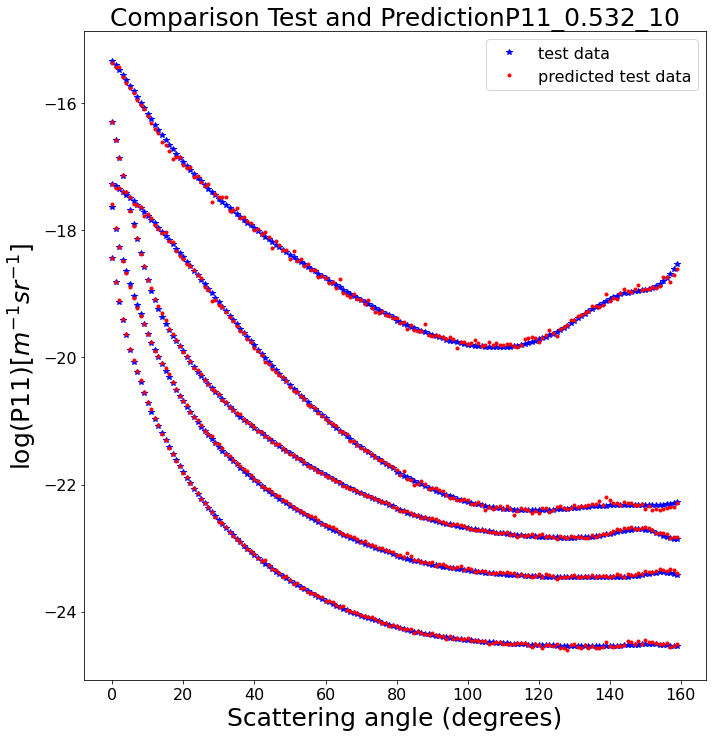

In [75]:
for wl_item in wl_list_P11:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred_fw[wl_item].iloc[index],'r.')

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('log(P11)[$m^{-1}sr^{-1}$]',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

In [76]:
for wl_item in wl_list_P12:
    if len(wl_item) != 0:
        fig, ax = plt.subplots(figsize = (10,10))
        for index in presentation_plot_index:
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_test[wl_item].iloc[index],'b*')
            ax.plot(np.arange(0,len(qoi_test[wl_item].iloc[index])),qoi_pred_fw[wl_item].iloc[index],'r.')
    
    

        ax.set_xlabel('Scattering angle (degrees)',fontsize = 25)
        ax.set_ylabel('P11\P12',fontsize = 25)
        ax.tick_params(labelsize = 16)    
        fig.tight_layout() 
        ax.set_title( 'Comparison Test and Prediction'+wl_item[0],fontsize = 25)
        ax.legend(['test data', 'predicted test data'], fontsize = 16)
        fig.savefig(f'{plot_dir}/phase_data__result_iv'+str(wl_item[0])+'.jpg')

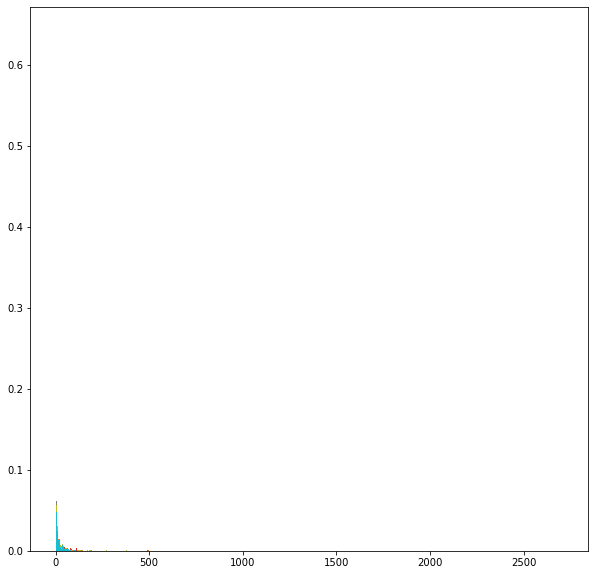

In [77]:
fig, ax = plt.subplots(figsize = (10,10))

x1data = []
x2data = []
y1data = []
y2data = []

for datapoint in presentation_plot_index:
    mu1 = dvar_pred_iv.iloc[datapoint]['R_median']
    sigma1 = dvar_pred_iv.iloc[datapoint]['GSD']
    mu2 = dvar_test.iloc[datapoint]['R_median']
    sigma2 = dvar_test.iloc[datapoint]['GSD']
    Vtot1 = dvar_pred_iv.iloc[datapoint]['V_tot']
    Vtot2 = dvar_test.iloc[datapoint]['V_tot']
    
    
    s1 = np.random.lognormal(mu1, sigma1, 10000)
    s2 = np.random.lognormal(mu2, sigma2, 10000)


    count1, bins1, ignored1 = plt.hist(s1, 10000, density=True, align='mid')
    count2, bins2, ignored2 = plt.hist(s2, 10000, density=True, align='mid')

    x1 = np.linspace(min(bins1), max(bins1), 100000)
    x2 = np.linspace(min(bins2), max(bins2), 100000)

    pdf1 = Vtot1*(np.exp(-(np.log(x1) - mu1)**2 / (2 * sigma1**2)) / (x1 * sigma1 * np.sqrt(2 * np.pi)))
    pdf2 = Vtot2*(np.exp(-(np.log(x2) - mu2)**2 / (2 * sigma2**2)) / (x2 * sigma2 * np.sqrt(2 * np.pi)))

    x1data.append(x1)
    x2data.append(x2)
    y1data.append(pdf1)
    y2data.append(pdf2)


0
1000
2000
5000


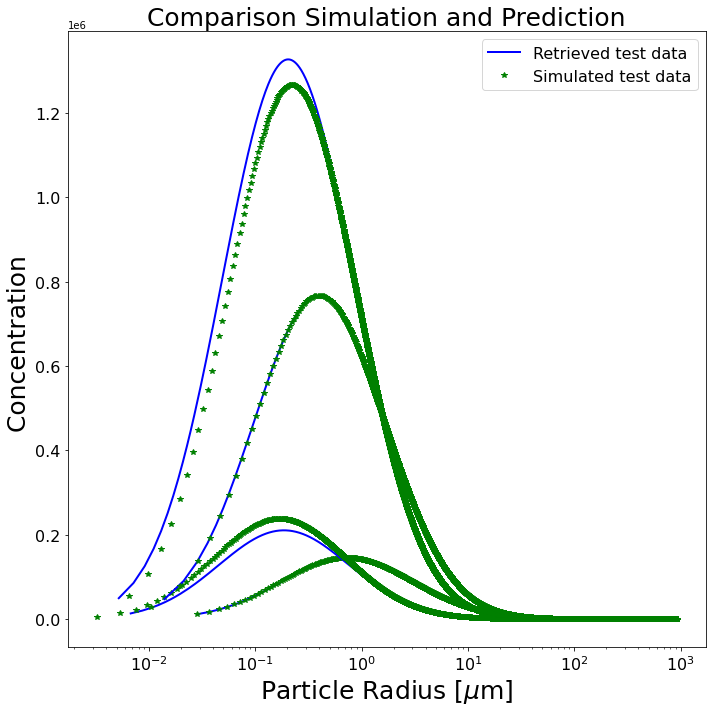

In [78]:
fig, ax = plt.subplots(figsize = (10,10))
for datalen in (0,1,2,3):
    print(presentation_plot_index[datalen])
     
    if datalen == 0:        
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1, label = 'Simulated test data')
    else:
        ax.plot(x1data[datalen], y1data[datalen]*1000,'b', linewidth=2)#,label ='Retrieved test data')
        ax.plot(x2data[datalen], y2data[datalen]*1000, '*g',linewidth=1)#, label = 'Simulated test data')
        
    
ax.legend(['Predicted test data', 'test data'], fontsize = 16)
ax.legend(fontsize = 16)   

ax.set_xlabel('Particle Radius [$\mu$m]',fontsize = 25)
ax.set_ylabel('Concentration ',fontsize = 25)
ax.tick_params(labelsize = 16)    
ax.set_title( 'Comparison Simulation and Prediction',fontsize = 25)
fig.align_labels()

plt.xscale('log')
#plt.yscale('log')
fig.tight_layout() 
fig.savefig(f'{plot_dir}/GSD_GMR_iv.jpg')

# plot correlation test data and predicted test data

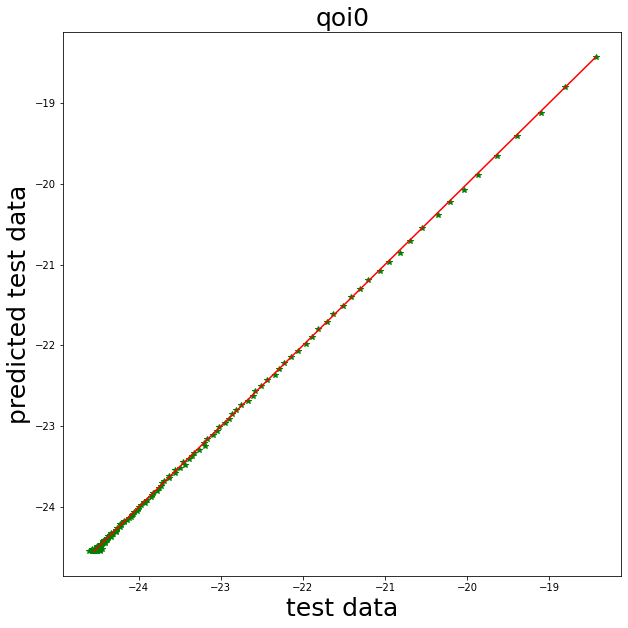

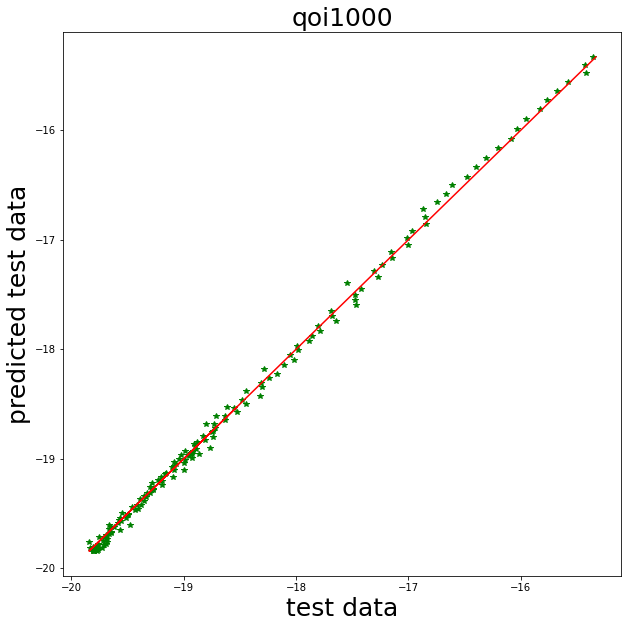

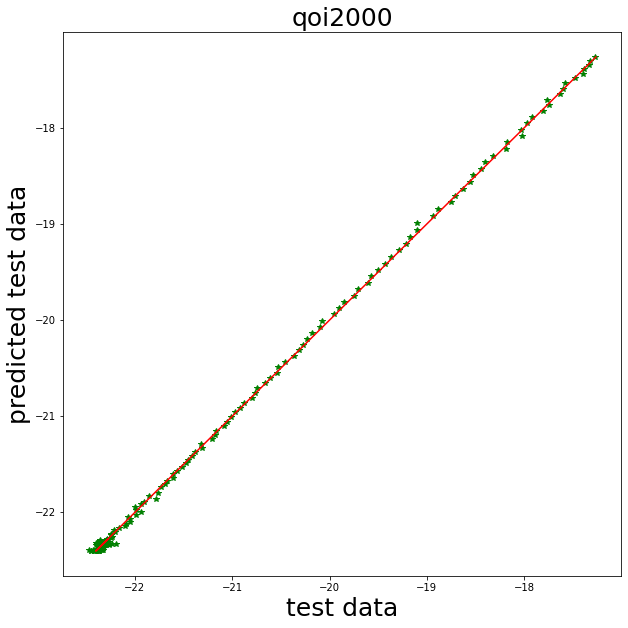

In [79]:
for index in presentation_plot_index:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(qoi_pred_fw.iloc[index],qoi_test.iloc[index],'g*')
    ax.plot(qoi_test.iloc[index],qoi_test.iloc[index],'r')
    ax.set_title('qoi'+str(index), fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

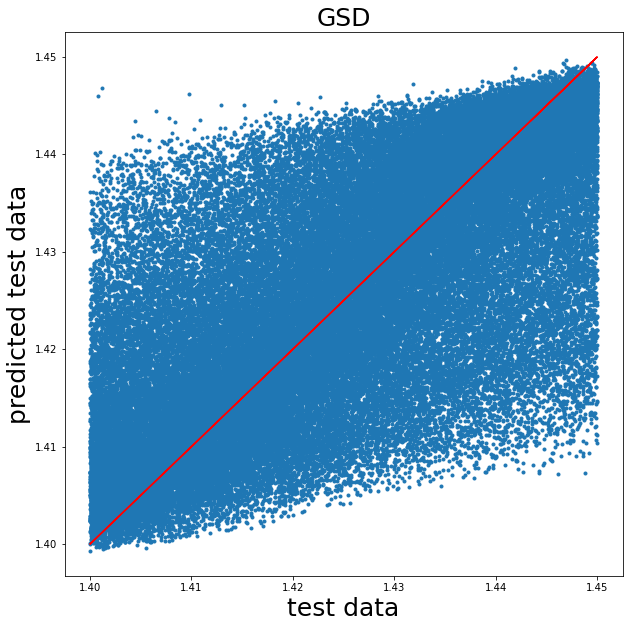

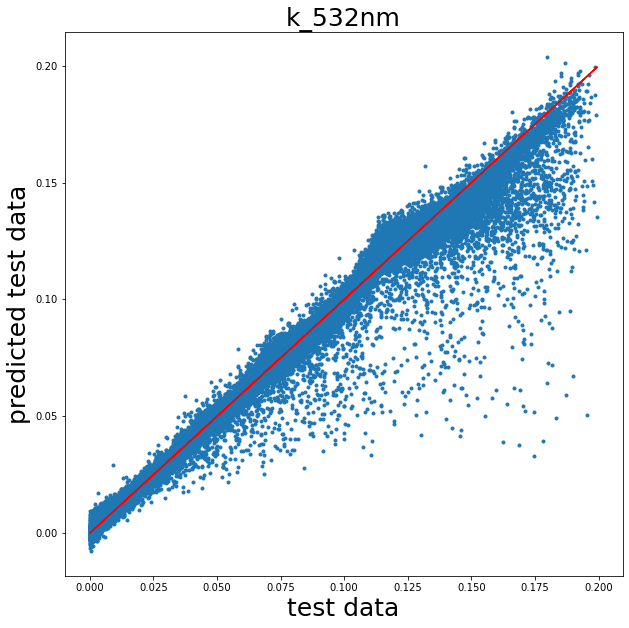

In [80]:
for key in dvar_columns:
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.plot(dvar_test[key],dvar_pred_iv[key],".")
    ax.plot(dvar_test[key],dvar_test[key],"r")
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

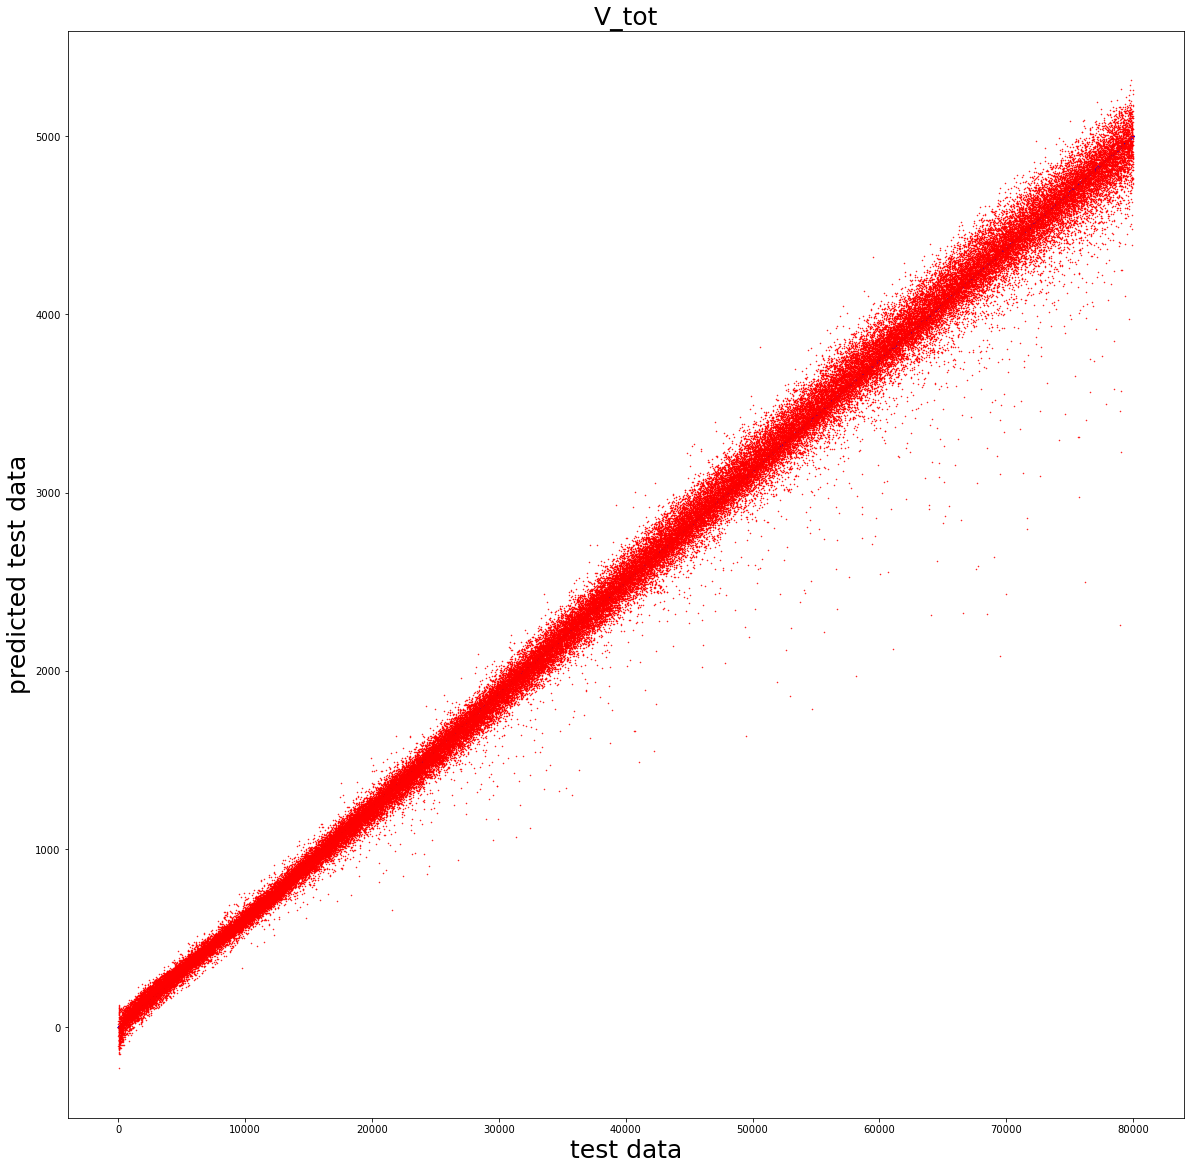

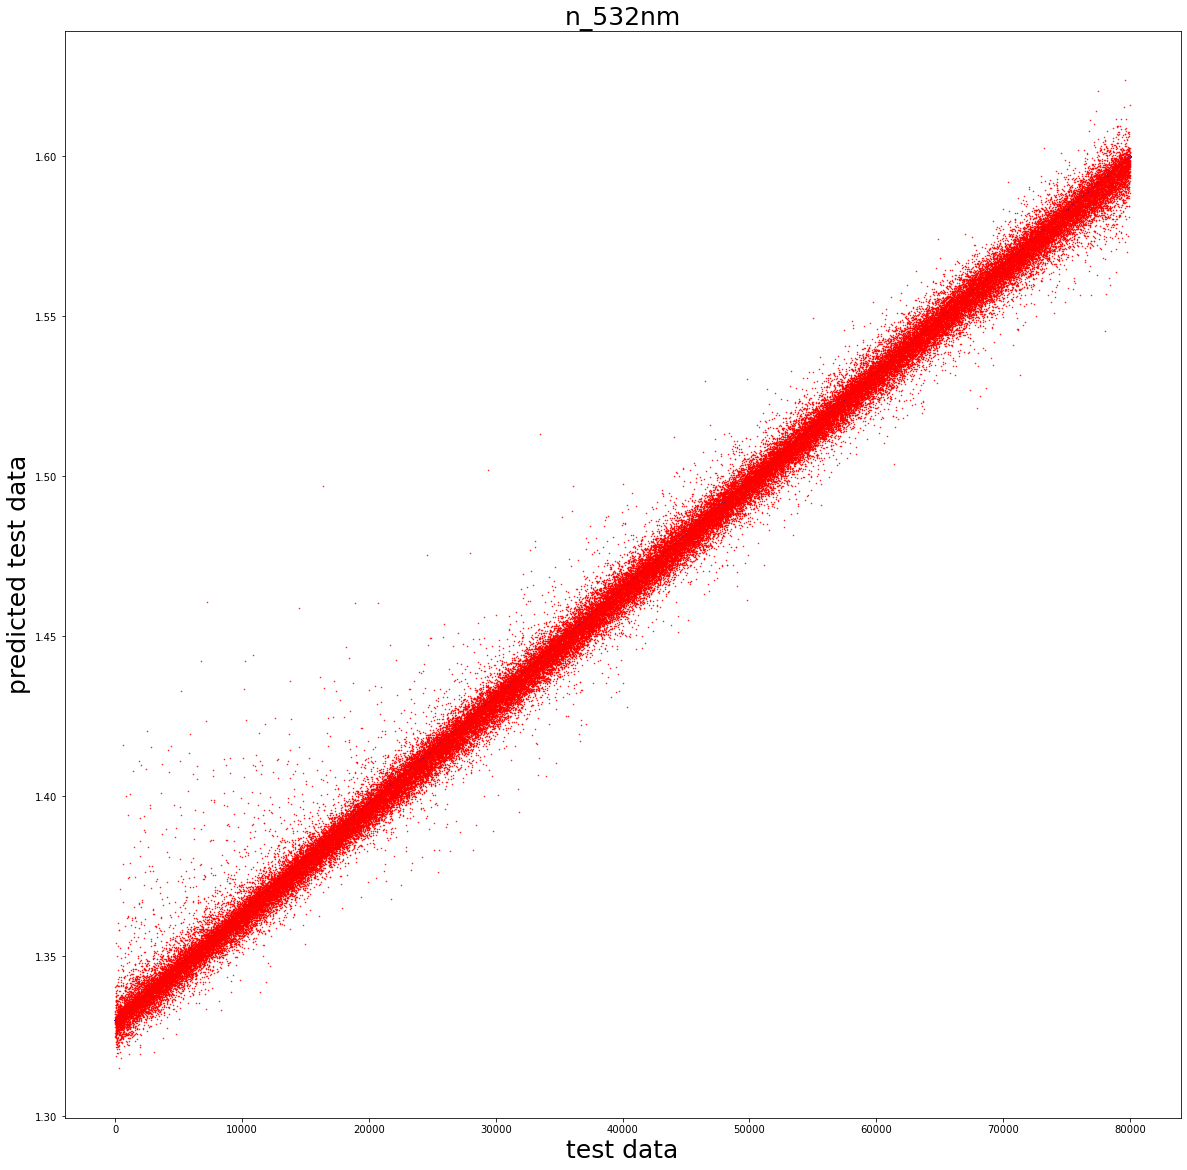

In [81]:
for key in dvar_test.columns:
    dvar_test_help = dvar_test.sort_values(key)
    dvar_pred_iv_df_help = dvar_pred_iv.loc[dvar_test_help.index]

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.plot(np.arange(0,len(dvar_test_help)),dvar_test_help[key],'b.', markersize = '1')
    ax.plot(np.arange(0,len(dvar_pred_iv_df_help)),dvar_pred_iv_df_help[key],'r.', markersize = '1')
    ax.set_title(key, fontsize = 25)
    ax.set_xlabel('test data',fontsize = 25)
    ax.set_ylabel('predicted test data',fontsize = 25)

# plot r2 for forward and inverse model

In [82]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
ax.set_ylabel('r2_adj')

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.savefig(f'{plot_dir}/invertible_model_fw_r2_adj.jpg')


In [83]:
fig, ax = plt.subplots(figsize=(16, 1.5), dpi=400)

sns.heatmap(r2_adj_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
      #      annot_kws={'fontsize': 20},
#            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

#fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_model_inv_r2_adj.jpg')



# Plot Relative Errors / Absolute errors

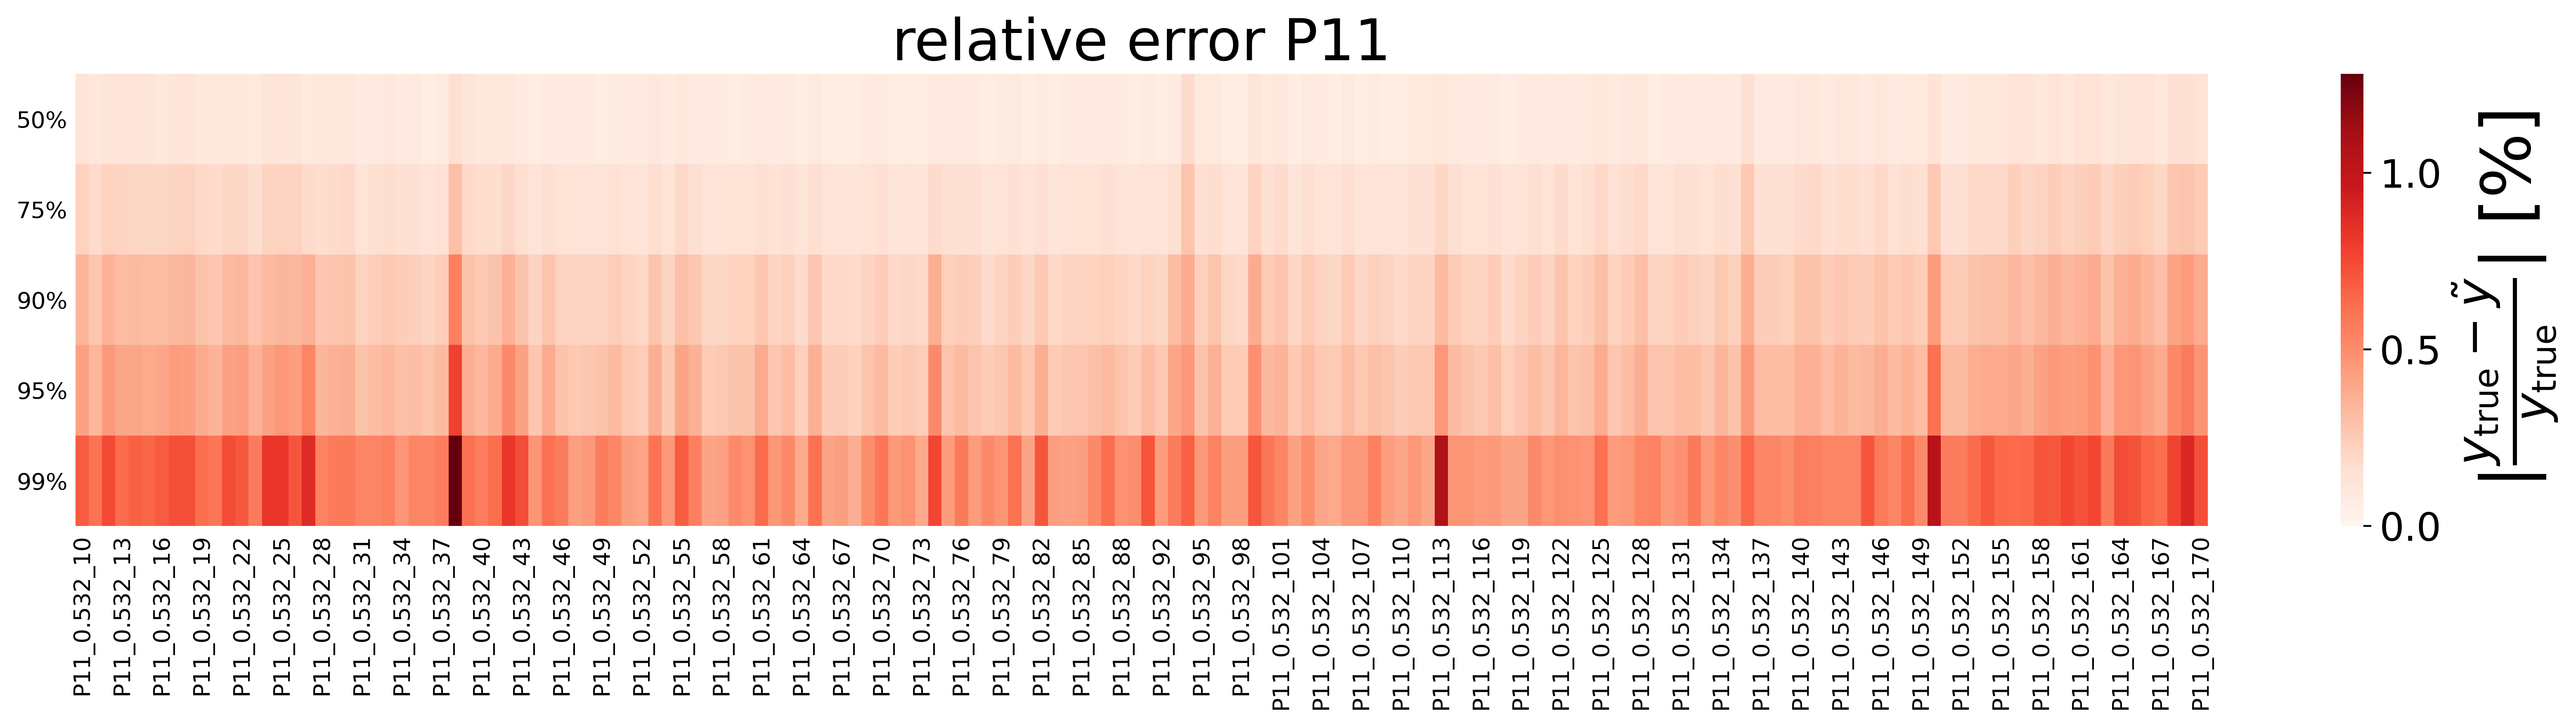

In [84]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_fw_P11,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_fw_P11.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('relative error P11', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))

fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

In [85]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(abs_error_table_fw_P12,
            cmap='Reds',
           # annot=True,
           # linewidths=2.,
            vmin=0.,
            vmax=np.max(abs_error_table_fw_P12.max()),
           # annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)
ax.set_title('absolute error P11/P12', fontsize =25)
fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/forward_rel_error_percentiles.jpg')

/data/user/boiger_r/python_env/aerosol_env_update/lib/python3.8/site-packages/seaborn/matrix.py:301: UserWarning: Attempting to set identical left == right == 0 results in singular transformations; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


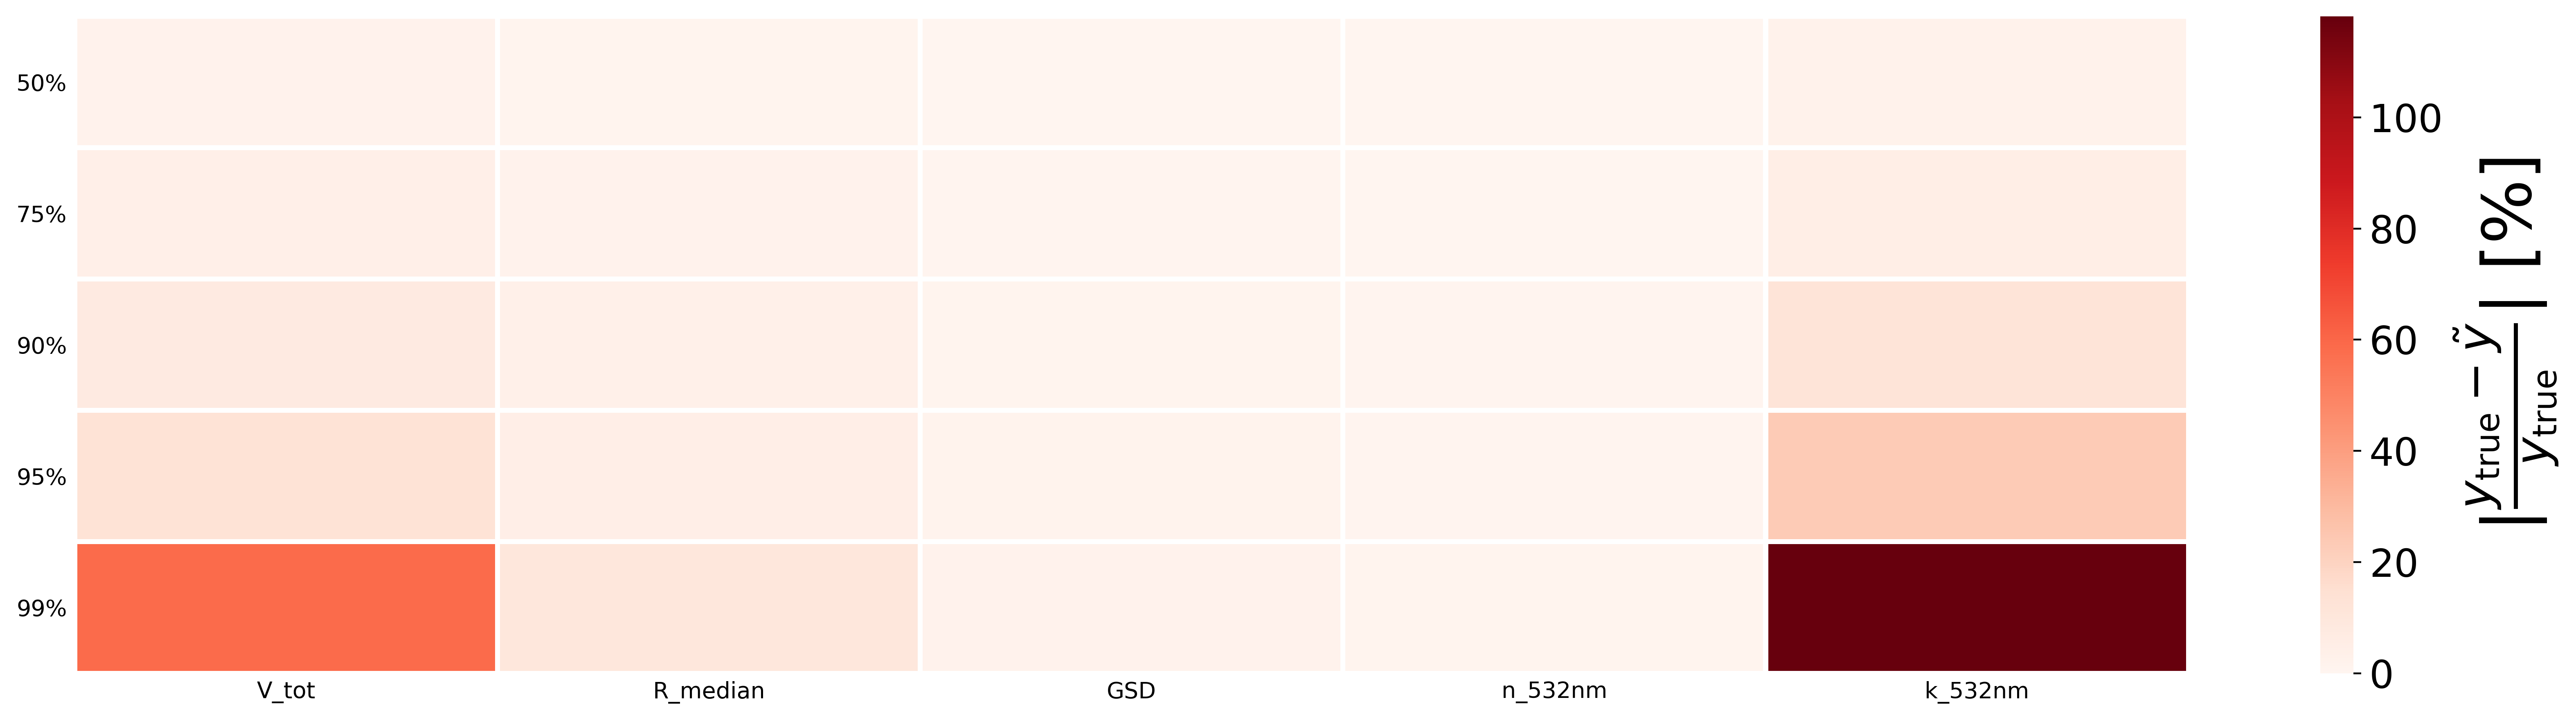

In [86]:
fig, ax = plt.subplots(figsize=(16, 4.5), dpi=400)

sns.heatmap(rel_error_table_iv,
            cmap='Reds',
       #     annot=False,
            linewidths=2.,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
      #      annot_kws={'fontsize': 20},
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'},
            ax=ax)
ax.tick_params(labelsize=10, length=0)
ax.tick_params(axis='y', rotation=0)
#ax.xaxis.tick_top()

# adjust the size of the colorbar label
fig.axes[1].set_ylabel(fig.axes[1].get_ylabel(), fontsize=30);
fig.axes[1].tick_params(labelsize=17)

fig.tight_layout(rect=(0, 0, 1.05, 1))
fig.savefig(f'{plot_dir}/invertible_sampling_rel_error_percentiles.jpg')


In [87]:
# Rework plots below

In [88]:
surr.model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 162)]             0         
_________________________________________________________________
affine_coupling_block (Affin (None, 162)               94532     
_________________________________________________________________
permutation_layer (Permutati (None, 162)               0         
_________________________________________________________________
affine_coupling_block_1 (Aff (None, 162)               94532     
_________________________________________________________________
permutation_layer_1 (Permuta (None, 162)               0         
_________________________________________________________________
affine_coupling_block_2 (Aff (None, 162)               94532     
Total params: 283,596
Trainable params: 283,596
Non-trainable params: 0
_______________________________________________________

In [89]:
from keras.utils.vis_utils import plot_model

ModuleNotFoundError: No module named 'keras'

In [ ]:
plot_model(surr.model, show_shapes=False,show_layer_names=True,to_file = f'{plot_dir}/model_architecture_invertible.png')


In [ ]:
r2_adj_fw = r2_adj_fw.rename({0: 'r2_adj'}, axis='index')
r2_adj_iv = r2_adj_iv.rename({0: 'r2_adj'}, axis='index')


# create overview plot

In [ ]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_fw,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_fw.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_fw,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_fw.jpg')
'''


In [ ]:
'''# Plot figure with subplots of different sizes
fig = plt.figure(1)
# set up subplot grid
gridspec.GridSpec(7,3)

plt.subplot2grid((7,3), (0,0), colspan=3, rowspan=1)
sns.heatmap(r2_adj_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=1.,
            xticklabels= False)
plt.tick_params(labelsize = 16)    
plt.title( 'Adjusted R2',fontsize = 25)

plt.subplot2grid((7,3), (1,0), colspan =3, rowspan =1)
sns.heatmap(rel_error_table_iv,
            cmap='Reds',
            linewidths=0.01,
            vmin=0.,
            vmax=np.max(rel_error_table_iv.max()),
            xticklabels = False,
            cbar_kws={'label': r'$\left| \frac{y_\mathrm{true} - \tilde{y}}{y_\mathrm{true}} \right|$ [%]'})
plt.tick_params(labelsize = 16)    
plt.title( 'Relative Error',fontsize = 25)


#plt.subplot2grid((7,3), (2,0),colspan = 3, rowspan = 2)
#sns.heatmap(to_plot_iv,
#            vmin=-1.,
#            vmax=1.,
#            linewidths = 0.01,
#            cmap='coolwarm',)
#plt.tick_params(labelsize = 16)
#plt.title( 'Correlation between DVARs and QOIs',fontsize = 25)

plt.subplot2grid((7,3), (5,0), colspan = 2, rowspan = 2)
for index in presentation_plot_index:
    plot_test_data = plt.plot(np.arange(3,len(qoi_test.columns)+3),qoi_test.iloc[index],'b*')
    plot_pred_data = plt.plot(np.arange(3,len(qoi_pred_fw.columns)+3),qoi_pred_fw.iloc[index],'r.')
plt.xlabel('Scattering angle (degrees)',fontsize = 25)
plt.ylabel('P11[$m^{-1}sr^{-1}$]',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.title( 'Comparison Test and Prediction',fontsize = 25)
#fig.align_labels()
plt.legend(['Test data', 'Predicted test data'], fontsize = 16)
#get_legend().get_title().set_fontsize('16')


plt.subplot2grid((7,3), (5,2), colspan = 1, rowspan = 1)
for index in qoi_test.index.values:
    plt.plot(qoi_test.iloc[index],qoi_pred_fw.iloc[index],'b*')
plt.title( 'Comparison Test and Prediction',fontsize = 25)    
plt.xlabel('Test data',fontsize = 25)
plt.ylabel('Predicted test data ',fontsize = 25)
plt.tick_params(labelsize = 16)    
plt.axline([-25, -25], [-8, -8])


fig.set_size_inches(w=30,h=30)
fig.savefig(f'{plot_dir}/overview_invertible_model_iv.jpg')
'''


In [ ]:
configs = pd.read_csv(f'{model_dir}/configs.csv')
configs.columns

In [ ]:
store_results = pd.DataFrame()


In [ ]:
store_results['data_file'] = configs['config/datafile']
store_results['batch_size'] = configs['config/batch_size']
store_results['learning_rate'] = configs['config/learning_rate']
store_results['n_blocks'] = configs['config/n_blocks']
store_results['n_depth'] = configs['config/n_depth']
store_results['n_width'] = configs['config/n_width']
store_results['weight_x'] = configs['config/weight_x']
store_results['weight_y'] = configs['config/weight_y']
store_results['weight_z'] = configs['config/weight_z']
store_results['weight_artificial'] = configs['config/weight_artificial']
store_results['weight_reconstruction'] = configs['config/weight_reconstruction']
store_results['r2_val_qoi_mean'] = configs['r2_val']
store_results['r2_test_qoi_mean'] = r2_adj_fw.mean(axis =1).values
if 'P11' in qoi_columns[0]:
    store_results['rel_error95%_qoi_P11_max'] = rel_error_table_fw_P11.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P11_max'] = abs_error_table_fw_P11.max(axis = 1)['95%']
else:
    store_results['rel_error95%_qoi_P11_max'] = 0
    store_results['abs_error95%_qoi_P11_max'] = 0
if 'P12' in qoi_columns[-1]:
    store_results['rel_error95%_qoi_P12_max'] = rel_error_table_fw_P12.max(axis = 1)['95%']
    store_results['abs_error95%_qoi_P12_max'] = abs_error_table_fw_P12.max(axis = 1)['95%']
else:    
    store_results['rel_error95%_qoi_P12_max'] = 0
    store_results['rel_error95%_qoi_P12_max'] = 0
store_results['MAE_qoi_max'] = MAE_all_qoi.max(axis= 1).values
store_results['MAPE%_qoi_max'] = MAPE_all_qoi.max(axis= 1).values
store_results['explained_variance_qoi_min'] = EVS_all_df.min(axis = 1)

store_results['r2_val_dvar_mean'] = configs['r2_val_dvar']
store_results['r2_test_dvar_mean'] = r2_adj_iv.mean(axis = 1).values



store_results['r2_test_dvar_V'] = r2_adj_iv['V_tot']['r2_adj']
store_results['rel_error95%_dvar_V'] = rel_error_table_iv['V_tot']['95%']
store_results['abs_error95%_dvar_V'] = abs_error_table_iv['V_tot']['95%']
store_results['MAE_dvar_V'] = MAE_all_dvar['V_tot'].values
store_results['MAPE%_dvar_V'] = MAPE_all_dvar['V_tot'].values
store_results['explained_variance_dvar_V'] = EVS_dvar['V_tot']

store_results['r2_test_dvar_R'] = r2_adj_iv['R_median']['r2_adj']
store_results['rel_error95%_dvar_R'] = rel_error_table_iv['R_median']['95%']
store_results['abs_error95%_dvar_R'] = abs_error_table_iv['R_median']['95%']
store_results['MAE_dvar_R'] = MAE_all_dvar['R_median'].values
store_results['MAPE%_dvar_R'] = MAPE_all_dvar['R_median'].values
store_results['explained_variance_dvar_R'] = EVS_dvar['R_median']

store_results['r2_test_dvar_GSD'] = r2_adj_iv['GSD']['r2_adj']
store_results['rel_error95%_dvar_GSD'] = rel_error_table_iv['GSD']['95%']
store_results['abs_error95%_dvar_GSD'] = abs_error_table_iv['GSD']['95%']
store_results['MAE_dvar_GSD'] = MAE_all_dvar['GSD'].values
store_results['MAPE%_dvar_GSD'] = MAPE_all_dvar['GSD'].values
store_results['explained_variance_dvar_GSD'] = EVS_dvar['GSD']

if 'n' in dvar_columns:  
    store_results['r2_test_dvar_n'] = r2_adj_iv['n']['r2_adj']
    store_results['rel_error95%_dvar_n'] = rel_error_table_iv['n']['95%']
    store_results['abs_error95%_dvar_n'] = abs_error_table_iv['n']['95%']
    store_results['MAE_dvar_n'] = MAE_all_dvar['n'].values
    store_results['MAPE%_dvar_n'] = MAPE_all_dvar['n'].values
    store_results['explained_variance_dvar_n'] = EVS_dvar['n']
else:
    store_results['r2_test_dvar_n'] = 0
    store_results['rel_error95%_dvar_n'] = 0
    store_results['abs_error95%_dvar_n'] = 0
    store_results['MAE_dvar_n'] = 0
    store_results['MAPE%_dvar_n'] = 0
    store_results['explained_variance_dvar_n'] = 0   



if 'n_532nm' in dvar_columns:    
    store_results['r2_test_dvar_n_532'] = r2_adj_iv['n_532nm']['r2_adj']
    store_results['rel_error95%_dvar_n_532'] = rel_error_table_iv['n_532nm']['95%']
    store_results['abs_error95%_dvar_n_532'] = abs_error_table_iv['n_532nm']['95%']
    store_results['MAE_dvar_n_532'] = MAE_all_dvar['n_532nm'].values
    store_results['MAPE%_dvar_n_532'] = MAPE_all_dvar['n_532nm'].values
    store_results['explained_variance_dvar_n_532'] = EVS_dvar['n_532nm']

else:
    store_results['r2_test_dvar_n_532'] = 0
    store_results['rel_error95%_dvar_n_532'] = 0
    store_results['abs_error95%_dvar_n_532'] = 0
    store_results['MAE_dvar_n_532'] = 0
    store_results['MAPE%_dvar_n_532'] = 0
    store_results['explained_variance_dvar_n_532'] = 0


if 'k_532nm' in dvar_columns:    
    store_results['r2_test_dvar_k_532'] = r2_adj_iv['k_532nm']['r2_adj']
    store_results['rel_error95%_dvar_k_532'] = rel_error_table_iv['k_532nm']['95%']
    store_results['abs_error95%_dvar_k_532'] = abs_error_table_iv['k_532nm']['95%']
    store_results['MAE_dvar_k_532'] = MAE_all_dvar['k_532nm'].values
    store_results['MAPE%_dvar_k_532'] = MAPE_all_dvar['k_532nm'].values
    store_results['explained_variance_dvar_k_532'] = EVS_dvar['k_532nm']

else:
    store_results['r2_test_dvar_k_532'] = 0
    store_results['rel_error95%_dvar_k_532'] = 0
    store_results['abs_error95%_dvar_k_532'] = 0
    store_results['MAE_dvar_k_532'] = 0
    store_results['MAPE%_dvar_k_532'] = 0
    store_results['explained_variance_dvar_k_532'] = 0
    
if 'n_450nm' in dvar_columns:  
    store_results['r2_test_dvar_n_450'] = r2_adj_iv['n_450nm']['r2_adj']
    store_results['rel_error95%_dvar_n_450'] = rel_error_table_iv['n_450nm']['95%']
    store_results['abs_error95%_dvar_n_450'] = abs_error_table_iv['n_450nm']['95%']
    store_results['MAE_dvar_n_450'] = MAE_all_dvar['n_450nm'].values
    store_results['MAPE%_dvar_n_450'] = MAPE_all_dvar['n_450nm'].values
    store_results['explained_variance_dvar_n_450'] = EVS_dvar['n_450nm']
    
else:
    store_results['r2_test_dvar_n_450'] = 0
    store_results['rel_error95%_dvar_n_450'] = 0
    store_results['abs_error95%_dvar_n_450'] = 0
    store_results['MAE_dvar_n_450'] = 0
    store_results['MAPE%_dvar_n_450'] = 0
    store_results['explained_variance_dvar_n_450'] = 0
    
if 'k_450nm' in dvar_columns:  
    store_results['r2_test_dvar_k_450'] = r2_adj_iv['k_450nm']['r2_adj']
    store_results['rel_error95%_dvar_k_450'] = rel_error_table_iv['k_450nm']['95%']
    store_results['abs_error95%_dvar_k_450'] = abs_error_table_iv['k_450nm']['95%']
    store_results['MAE_dvar_k_450'] = MAE_all_dvar['k_450nm'].values
    store_results['MAPE%_dvar_k_450'] = MAPE_all_dvar['k_450nm'].values
    store_results['explained_variance_dvar_k_450'] = EVS_dvar['k_450nm']
    
else:
    store_results['r2_test_dvar_k_450'] = 0
    store_results['rel_error95%_dvar_k_450'] = 0
    store_results['abs_error95%_dvar_k_450'] = 0
    store_results['MAE_dvar_k_450'] = 0
    store_results['MAPE%_dvar_k_450'] = 0
    store_results['explained_variance_dvar_k_450'] = 0
    
if 'n_630nm' in dvar_columns:    
    store_results['r2_test_dvar_n_630'] = r2_adj_iv['n_630nm']['r2_adj']
    store_results['rel_error95%_dvar_n_630'] = rel_error_table_iv['n_630nm']['95%']
    store_results['abs_error95%_dvar_n_630'] = abs_error_table_iv['n_630nm']['95%']
    store_results['MAE_dvar_n_630'] = MAE_all_dvar['n_630nm'].values
    store_results['MAPE%_dvar_n_630'] = MAPE_all_dvar['n_630nm'].values
    store_results['explained_variance_dvar_n_630'] = EVS_dvar['n_630nm']
else:
    store_results['r2_test_dvar_n_630'] = 0
    store_results['rel_error95%_dvar_n_630'] = 0
    store_results['abs_error95%_dvar_n_630'] = 0
    store_results['MAE_dvar_n_630'] =0
    store_results['MAPE%_dvar_n_630'] =0
    store_results['explained_variance_dvar_n_630'] = 0
      
    
if 'k_630nm' in dvar_columns:    
    store_results['r2_test_dvar_k_630'] = r2_adj_iv['k_630nm']['r2_adj']
    store_results['rel_error95%_dvar_k_630'] = rel_error_table_iv['k_630nm']['95%']
    store_results['abs_error95%_dvar_k_630'] = abs_error_table_iv['k_630nm']['95%']
    store_results['MAE_dvar_k_630'] = MAE_all_dvar['k_630nm'].values
    store_results['MAPE%_dvar_k_630'] = MAPE_all_dvar['k_630nm'].values
    store_results['explained_variance_dvar_k_630'] = EVS_dvar['k_630nm']
else:
    store_results['r2_test_dvar_k_630'] = 0
    store_results['rel_error95%_dvar_k_630'] = 0
    store_results['abs_error95%_dvar_k_630'] = 0
    store_results['MAE_dvar_k_630'] =0
    store_results['MAPE%_dvar_k_630'] =0
    store_results['explained_variance_dvar_k_630'] = 0
    







store_results['preprocessor_x'] = configs['config/preprocessor_x']
store_results['preprocessor_y'] = configs['config/preprocessor_y']

In [ ]:
store_results.to_csv(f'{model_dir}/results_summary1.csv')


In [ ]:
store_results

In [ ]:
model_dir